# 승촌보: 방류량 중요도

## 데이터 정보

* 승촌보 수질 데이터(Seungchonbo.xlsx)   
    * 2012-2022년  
    * 시간 단위 수집 데이터
* 승촌보 유량 데이터(Seungchonbo_flow.xlsx)
    * 2012-2022년
    * 10분 단위 수집 데이터

## 주요 내용

- GB 모델을 활용하여 지난 시간동안의 방류량이 중요함을 확인한다.
- 단지 하룻동안이 아닌 2, 3일 동안의 평균 방류량이 클로로필-a 농도를 예측할 때 가장 중요한 요소로 작동함을 입증한다.

## 필수 모듈 임포트

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from datetime import datetime
import datetime as dt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# 모델 저장
import joblib

**그래프 설정**

In [3]:
# seaborn 스타일 지정
# sns.set_style("whitegrid")
sns.set_style("white")

plt.rc('figure', figsize=(10, 6))  # 그래프 기본 크기 지정
plt.rc('font', size=22)            # 폰트 크기
plt.rc('axes', linewidth=2)        # 축 두께
plt.rc('axes', edgecolor='k')      # 축 색상

# show tick marks
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

# Set the default font
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.serif'] = ['Times New Roman']

**그래프 한글 설정**

In [4]:
# # 운영체제에 따른 한글 지원을 설정한다. 지원되는 환경은 윈도우, 우분투, 구글 코랩 등이다.

# import platform
# plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
# if platform.system() == 'Windows': # 윈도우
#     from matplotlib import font_manager, rc
#     font_path = "C:/Windows/Fonts/gulim.ttc"
#     font = font_manager.FontProperties(fname=font_path).get_name()
#     rc('font', family=font)
# elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
#     # !sudo apt-get install -y fonts-nanum*
#     # !fc-cache -fv
    
#     applyfont = "NanumBarunGothic"
#     import matplotlib.font_manager as fm
#     if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
#         fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
#     plt.rc("font", family=applyfont)
#     plt.rc("axes", unicode_minus=False)

**이미지 저장 함수**

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, fig_extension="png", tight_layout=True, resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from datetime import datetime
import datetime as dt

## 승촌보 데이터 불러오기

### 수질 데이터 불러오기

**보 이름**

In [7]:
weir = 'Seungchonbo'

**데이터 저장소**

In [8]:
base_path = "https://github.com/codingalzi/water-data/raw/master/weirs/data/"

**시간 단위로 측정된 승촌보 연도별 수질 데이터 불러오기**

`'측정일/월'` 특성은 date time으로 파싱.

In [9]:
# ! pip install openpyxl

In [10]:
# '측정일/월' 특성은 date time으로 파싱.
# 반환값은 연도별 데이터프레임으로 구성된 사전. 2012년 ~ 2022년

data_file = weir+".xlsx"
scb_yearly = pd.read_excel(base_path+data_file, 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 측정일/월 특성을 date time으로 파싱

**2012년도 데이터를 제외한 모든 데이터 통합 함수**

2012년도 데이터는 결측치가 너무 많음.

In [11]:
# 2013년도 데이터부터 합침
# 반환값은 데이터프레임

def concat_yearly_df(df_yearly_dict):
    df_concat = pd.DataFrame()

    for year in list(df_yearly_dict.keys())[1:]:
        df_concat = pd.concat([df_concat, df_yearly_dict[year]])

    return df_concat

**연도별 수질 데이터 통합**

In [12]:
# 2013년도부터 통합
scb_yearly_df13 = concat_yearly_df(scb_yearly)

In [13]:
scb_yearly_df13.columns

Index(['측정일/월', '측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥'],
      dtype='object')

In [14]:
scb_yearly_df13

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00:00:00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
1,2013-01-01 01:00:00,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2,2013-01-01 02:00:00,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
3,2013-01-01 03:00:00,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
4,2013-01-01 04:00:00,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9
...,...,...,...,...,...,...,...,...,...,...
3427,2022-05-23 19:00:00,용봉,26.6,6.9,419.0,NaN,6.7,5.825,0.108,66.2
3428,2022-05-23 20:00:00,용봉,26.3,6.8,425.0,NaN,6.5,5.803,0.107,61.2
3429,2022-05-23 21:00:00,용봉,25.9,6.8,417.0,NaN,6.7,5.909,0.107,58.3
3430,2022-05-23 22:00:00,용봉,25.7,6.8,420.0,NaN,6.4,5.921,0.106,54.4


**인덱스 지정 및 이름 수정**

인덱스를 `'측정일/월'` 특성으로 변경한다.

In [15]:
scb_yearly_df13 = scb_yearly_df13.set_index('측정일/월')

인덱스의 이름도 변경한다.

In [16]:
scb_yearly_df13.index.name = 'DateTime'

인덱스(`'DateTime'`) 기준으로 정렬한다.

In [17]:
scb_yearly_df13 = scb_yearly_df13.sort_index()

In [18]:
scb_yearly_df13

,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
DateTime,,,,,,,,,
2013-01-01 00:00:00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
2013-01-01 01:00:00,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2013-01-01 02:00:00,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
2013-01-01 03:00:00,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2013-01-01 04:00:00,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9
...,...,...,...,...,...,...,...,...,...
2022-05-23 19:00:00,용봉,26.6,6.9,419.0,NaN,6.7,5.825,0.108,66.2
2022-05-23 20:00:00,용봉,26.3,6.8,425.0,NaN,6.5,5.803,0.107,61.2
2022-05-23 21:00:00,용봉,25.9,6.8,417.0,NaN,6.7,5.909,0.107,58.3


### 승촌보 유량 데이터 추가

`시간` 특성은 date time으로 파싱해서 불러온다.

**10분 단위로 측정된 승촌보 연도별 유량 데이터 불러오기**

In [19]:
# `시간` 특성은 date time으로 파싱해서 불러온다.
# 반환값은 연도별 데이터프레임으로 구성된 사전. 2012년 ~ 2022년

flow_data_file = weir + "_flow.xlsx"
scb_flow_yearly = pd.read_excel(base_path+flow_data_file, 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 시간 특성을 date time으로 파싱

### 연도별 유량 데이터 통합

수질 데이터셋과 맞추기 위해 2012년도 데이터를 제외한 데이터를 통합한다.

In [20]:
# 2013년부터 통합
scb_flow_yearly_df = concat_yearly_df(scb_flow_yearly)

In [21]:
scb_flow_yearly_df

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2013-01-01 00:00:00,7.50,3.77,19.82,19.74
1,2013-01-01 00:10:00,7.50,3.77,19.78,19.76
2,2013-01-01 00:20:00,7.50,3.77,19.77,19.82
3,2013-01-01 00:30:00,7.50,3.77,19.77,19.73
4,2013-01-01 00:40:00,7.50,3.77,19.78,19.79
...,...,...,...,...,...
32947,2022-08-17 19:10:00,5.46,1.60,14.01,19.78
32948,2022-08-17 19:20:00,5.47,1.59,18.96,19.78
32949,2022-08-17 19:30:00,5.47,1.58,19.78,19.78
32950,2022-08-17 19:40:00,5.47,1.57,24.72,19.78


인덱스를 시간으로 지정

In [22]:
scb_flow_yearly_df = scb_flow_yearly_df.set_index('시간')

인덱스 이름도 수질 데이터와의 통합을 위해 동일한 이름으로 변경한다.

In [23]:
scb_flow_yearly_df.index.name = 'DateTime'

시간 기준으로 정렬

In [24]:
scb_flow_yearly_df = scb_flow_yearly_df.sort_index()

In [25]:
scb_flow_yearly_df

,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
DateTime,,,,
2013-01-01 00:00:00,7.50,3.77,19.82,19.74
2013-01-01 00:10:00,7.50,3.77,19.78,19.76
2013-01-01 00:20:00,7.50,3.77,19.77,19.82
2013-01-01 00:30:00,7.50,3.77,19.77,19.73
2013-01-01 00:40:00,7.50,3.77,19.78,19.79
...,...,...,...,...
2022-08-17 19:10:00,5.46,1.60,14.01,19.78
2022-08-17 19:20:00,5.47,1.59,18.96,19.78
2022-08-17 19:30:00,5.47,1.58,19.78,19.78


**10분 단위를 1시간 단위로 변경**

수질 데이터와의 통합을 위해 시간별 평균값을 활용한다.

In [26]:
scb_flow_yearly_hour_df = scb_flow_yearly_df.resample("H").mean()

In [27]:
scb_flow_yearly_hour_df

,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
DateTime,,,,
2013-01-01 00:00:00,7.500000,3.770000,19.773333,19.748333
2013-01-01 01:00:00,7.500000,3.770000,19.701667,19.706667
2013-01-01 02:00:00,7.500000,3.770000,19.748333,19.723333
2013-01-01 03:00:00,7.500000,3.770000,19.613333,19.610000
2013-01-01 04:00:00,7.500000,3.770000,19.661667,19.665000
...,...,...,...,...
2022-08-17 15:00:00,5.536667,1.618333,29.261667,25.190000
2022-08-17 16:00:00,5.525000,1.638333,23.243333,38.923333
2022-08-17 17:00:00,5.483333,1.626667,29.068333,44.878333


### 수질/유량 데이터 합병

수질 데이터와 유량 데이터를 `date/time` 기준으로 합병한다.

In [28]:
# `pd.merge()`에서 `how = 'inner'` 키워드 인자 : 두 데이터에 공통으로 사용된 시간 데이터만 추가(교집합).
scb_data = pd.merge(scb_yearly_df13, scb_flow_yearly_hour_df, left_index=True, right_index=True, how='inner')

In [29]:
# 유량 특성 이름에 공백이 사용되었기에 특성명에 공백 제거
scb_data.columns = [x.strip() for x in list(scb_data.columns)]

In [30]:
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82257 entries, 2013-01-01 00:00:00 to 2022-05-23 23:00:00
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정소명         82257 non-null  object 
 1   수온 ℃         64574 non-null  float64
 2   수소이온농도       64561 non-null  float64
 3   전기전도도 μS/cm  64524 non-null  float64
 4   용존산소 mg/L    62656 non-null  float64
 5   총유기탄소 mg/L   58675 non-null  float64
 6   총질소 mg/L     59981 non-null  float64
 7   총인 mg/L      58997 non-null  float64
 8   클로로필-a mg/㎥  62876 non-null  float64
 9   상류수위(EL.m)   82231 non-null  float64
 10  하류수위(EL.m)   82231 non-null  float64
 11  유입량(㎥/s)     82231 non-null  float64
 12  방류량(㎥/s)     82231 non-null  float64
dtypes: float64(12), object(1)
memory usage: 8.8+ MB


In [31]:
scb_data.describe()

,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
count,64574.000000,64561.000000,64524.000000,62656.000000,58675.000000,59981.000000,58997.000000,62876.000000,82231.000000,82231.000000,82231.000000,82231.000000
mean,17.309103,7.032307,344.310877,7.500954,4.341878,5.358875,0.118273,50.969729,6.451908,2.465385,32.146464,31.964258
std,8.099525,0.509260,88.450084,3.914830,1.032926,1.963933,0.062979,37.409147,1.528813,1.183083,113.291730,112.716473
min,1.800000,6.100000,92.000000,0.500000,1.600000,0.706000,0.003000,1.000000,2.600000,-0.756667,0.000000,0.000000
25%,9.400000,6.700000,280.000000,4.400000,3.600000,3.820000,0.074000,20.975000,5.570000,1.538333,11.320000,11.133333
50%,17.300000,6.900000,344.000000,7.600000,4.200000,5.097000,0.106000,43.200000,7.290000,2.546667,16.280000,15.108333
75%,24.700000,7.100000,415.000000,10.400000,5.000000,6.660000,0.148000,74.100000,7.520000,3.550000,25.570000,26.649167
max,36.100000,10.000000,730.000000,24.300000,19.300000,12.357000,0.745000,453.500000,157.920000,12.486667,4581.450000,4088.446667


### 이상치 제거

상류수위가 10 (EL.m) 이상인 데이터가 존재한다.
그런데 승촌보 수위는 그 이상이 될 수 없기에 이상치로 간주하고 삭제한다.

In [32]:
scb_data = scb_data[scb_data['상류수위(EL.m)'] <= 10]
scb_data.describe()

,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
count,64548.000000,64535.000000,64498.000000,62630.000000,58651.000000,59955.000000,58971.000000,62850.000000,82203.000000,82203.000000,82203.000000,82203.000000
mean,17.308639,7.032307,344.316087,7.501071,4.341445,5.359145,0.118258,50.971271,6.444988,2.463510,31.215314,31.095678
std,8.099587,0.509353,88.451036,3.914639,1.032804,1.963861,0.062981,37.413957,1.351669,1.175611,96.401627,96.811397
min,1.800000,6.100000,92.000000,0.500000,1.600000,0.706000,0.003000,1.000000,2.600000,-0.756667,0.000000,0.000000
25%,9.400000,6.700000,281.000000,4.400000,3.600000,3.821000,0.074000,20.900000,5.570000,1.538333,11.320000,11.133333
50%,17.300000,6.900000,344.000000,7.600000,4.200000,5.097000,0.106000,43.200000,7.290000,2.546667,16.280000,15.105000
75%,24.700000,7.100000,415.000000,10.400000,5.000000,6.659000,0.148000,74.100000,7.520000,3.550000,25.560000,26.636667
max,36.100000,10.000000,730.000000,24.300000,19.300000,12.357000,0.745000,453.500000,9.993333,9.925000,3630.926667,3430.493333


## 데이터셋 전처리

**특성 선택**

데이터 분석에 사용하지 않을 특성들은 삭제한다.

In [33]:
to_be_removed = ['측정소명', '수소이온농도', '용존산소 mg/L', '하류수위(EL.m)', '유입량(㎥/s)']

scb_data = scb_data.drop(to_be_removed, axis=1)

In [34]:
scb_data

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
DateTime,,,,,,,,
2013-01-01 00:00:00,3.9,374.0,2.5,NaN,NaN,7.2,7.50,19.748333
2013-01-01 01:00:00,3.9,375.0,2.5,NaN,NaN,6.9,7.50,19.706667
2013-01-01 02:00:00,4.0,374.0,2.5,NaN,NaN,6.8,7.50,19.723333
2013-01-01 03:00:00,4.1,375.0,2.5,NaN,NaN,6.9,7.50,19.610000
2013-01-01 04:00:00,4.0,380.0,2.6,NaN,NaN,6.9,7.50,19.665000
...,...,...,...,...,...,...,...,...
2022-05-23 19:00:00,26.6,419.0,6.7,5.825,0.108,66.2,5.44,12.766667
2022-05-23 20:00:00,26.3,425.0,6.5,5.803,0.107,61.2,5.44,12.786667
2022-05-23 21:00:00,25.9,417.0,6.7,5.909,0.107,58.3,5.44,12.743333


**특성 영문명 지정**

모델 훈련에 사용되는 모든 특성명을 영문으로 변경한다.
현재 남아 있는 특성들은 다음과 같다.

In [35]:
scb_data.columns

Index(['수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L',
       '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

각 특성의 영문명은 다음과 같다.

In [36]:
features_english = {
    '수온 ℃' : 'Temp',
    '전기전도도 μS/cm' : 'EC',
    '용존산소 mg/L' : 'DO',
    '총유기탄소 mg/L' : 'TOC',
    '총질소 mg/L' : 'TN',
    '총인 mg/L' : 'TP',
    '클로로필-a mg/㎥' : 'Chl-a',
    '상류수위(EL.m)' : 'WL',
    '하류수위(EL.m)' : 'Downstream',
    '유입량(㎥/s)' : 'Inflow',
    '방류량(㎥/s)' : 'D-Flow'
}

영문명으로 변경(renaming)한다.

In [37]:
scb_data = scb_data.rename(columns=features_english)
scb_data

,Temp,EC,TOC,TN,TP,Chl-a,WL,D-Flow
DateTime,,,,,,,,
2013-01-01 00:00:00,3.9,374.0,2.5,NaN,NaN,7.2,7.50,19.748333
2013-01-01 01:00:00,3.9,375.0,2.5,NaN,NaN,6.9,7.50,19.706667
2013-01-01 02:00:00,4.0,374.0,2.5,NaN,NaN,6.8,7.50,19.723333
2013-01-01 03:00:00,4.1,375.0,2.5,NaN,NaN,6.9,7.50,19.610000
2013-01-01 04:00:00,4.0,380.0,2.6,NaN,NaN,6.9,7.50,19.665000
...,...,...,...,...,...,...,...,...
2022-05-23 19:00:00,26.6,419.0,6.7,5.825,0.108,66.2,5.44,12.766667
2022-05-23 20:00:00,26.3,425.0,6.5,5.803,0.107,61.2,5.44,12.786667
2022-05-23 21:00:00,25.9,417.0,6.7,5.909,0.107,58.3,5.44,12.743333


### 클로로필 정규화

회귀 모델을 적용하기 전에 일평균 클로로필-a의 분포를 확인하면 왼쪽으로 치우친 형태를 보인다.

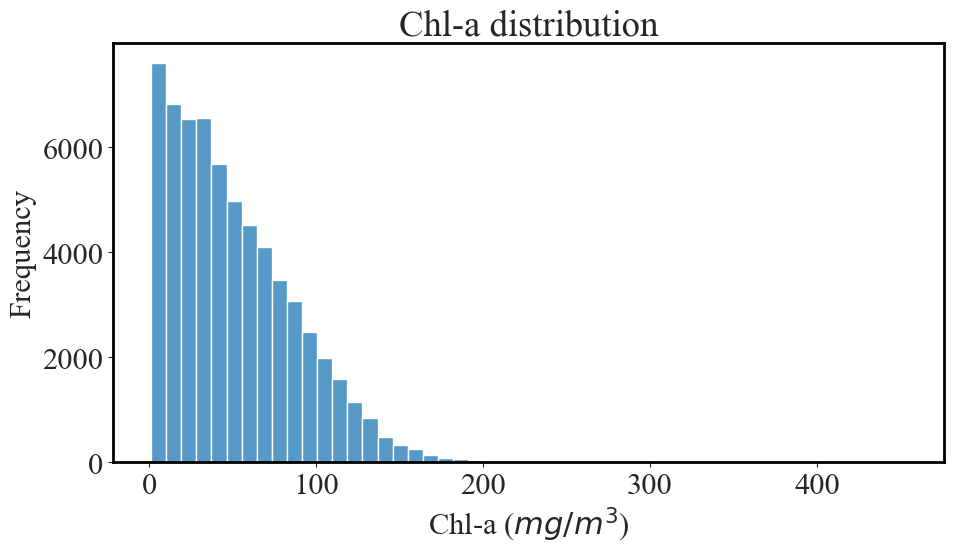

In [38]:
ax = sns.histplot(scb_data['Chl-a'], bins=50)

# xticks = np.arange(0, 201, 10)
# ax.set_xticks(xticks)
ax.set_xlabel('Chl-a ($mg/m^3$)')
ax.set_ylabel('Frequency')
ax.set_title('Chl-a distribution')

save_fig('hourly-Chl-a-hist')
plt.show()

클로로필-a 수치에 `np.log1p()`함수를 적용하여 용해 클로로필-a의 분포가 보다 정규 분포에 가까워지도록 한 다음에
보다 학습이 잘되는 회귀 모델을 얻을 수 있다.

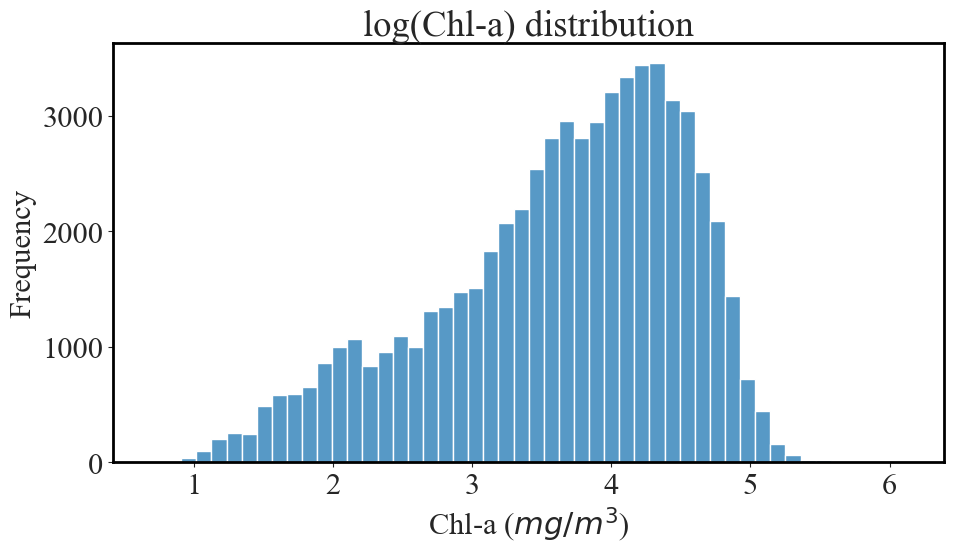

In [39]:
ax = sns.histplot(np.log1p(scb_data['Chl-a']), bins=50)

# xticks = np.arange(0, 201, 10)
# ax.set_xticks(xticks)
ax.set_xlabel('Chl-a ($mg/m^3$)')
ax.set_ylabel('Frequency')
ax.set_title('log(Chl-a) distribution')

save_fig('hourly-loc-Chl-a-hist')
plt.show()

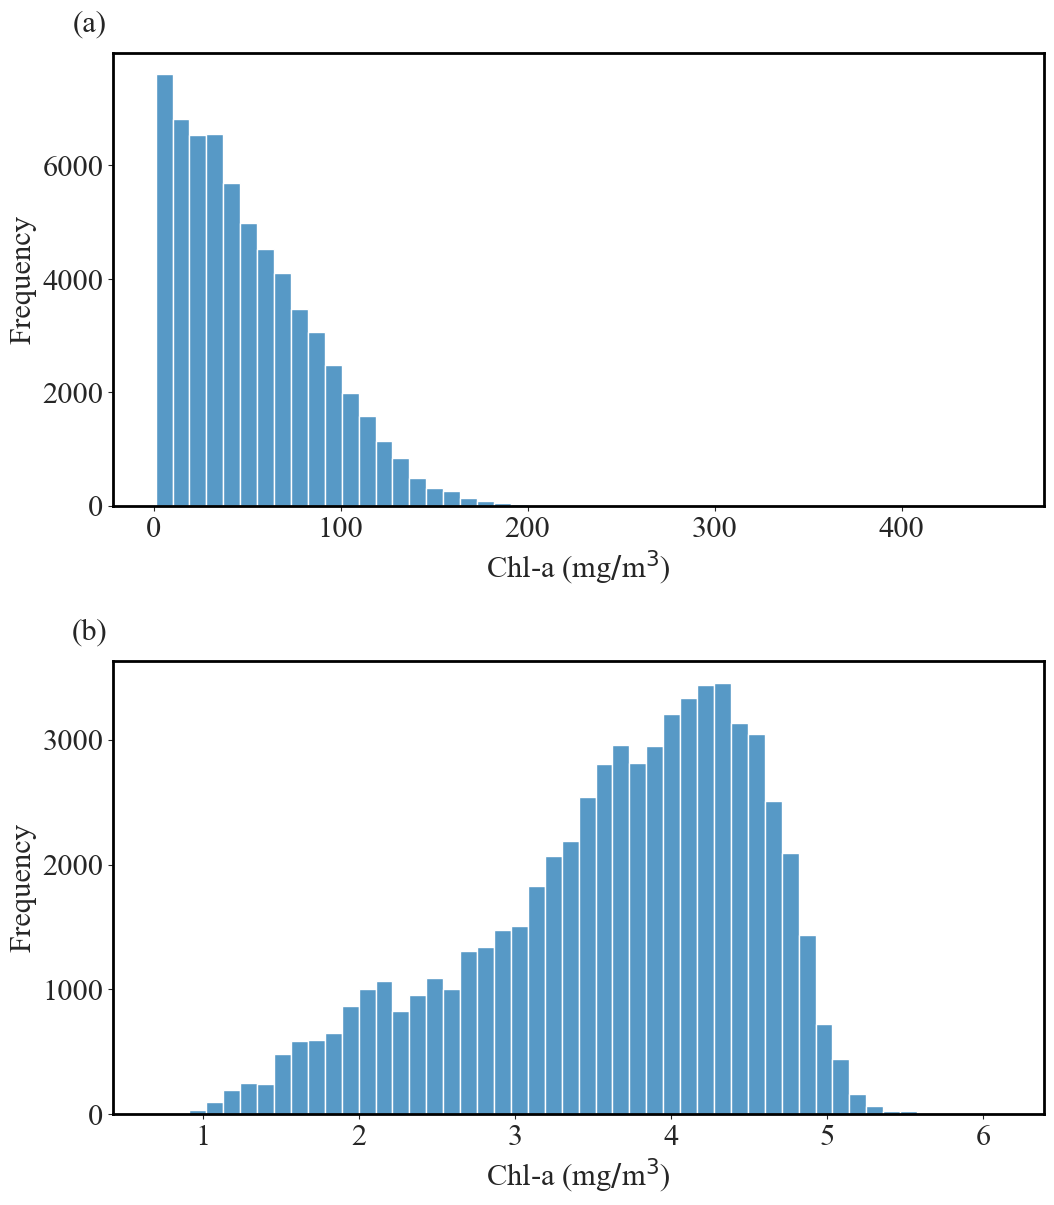

In [40]:
fig = plt.figure(figsize=(11, 12.5))
fig.subplots_adjust(hspace=0.33)

ax1 = fig.add_subplot(2, 1, 1)

ax1 = sns.histplot(scb_data['Chl-a'], bins=50)

# xticks = np.arange(0, 201, 10)
# ax1.set_xticks(xticks)
ax1.set_xlabel('Chl-a ($\mathdefault{mg}/\mathdefault{m}^3$)')
ax1.set_ylabel('Frequency')
# ax1.grid(axis='y')
ax1.set_title('(a)', y=1.03, x=-0.025, fontsize=22)

ax2 = fig.add_subplot(2, 1, 2)
ax2 = sns.histplot(np.log1p(scb_data['Chl-a']), bins=50)

# xticks = np.arange(0, 201, 10)
# ax2.set_xticks(xticks)
ax2.set_xlabel('Chl-a ($\mathdefault{mg}/\mathdefault{m}^3$)')
ax2.set_ylabel('Frequency')
# ax2.grid(axis='y')
ax2.set_title('(b)', y=1.03, x=-0.025, fontsize=22)

save_fig('figureS1')
plt.show()

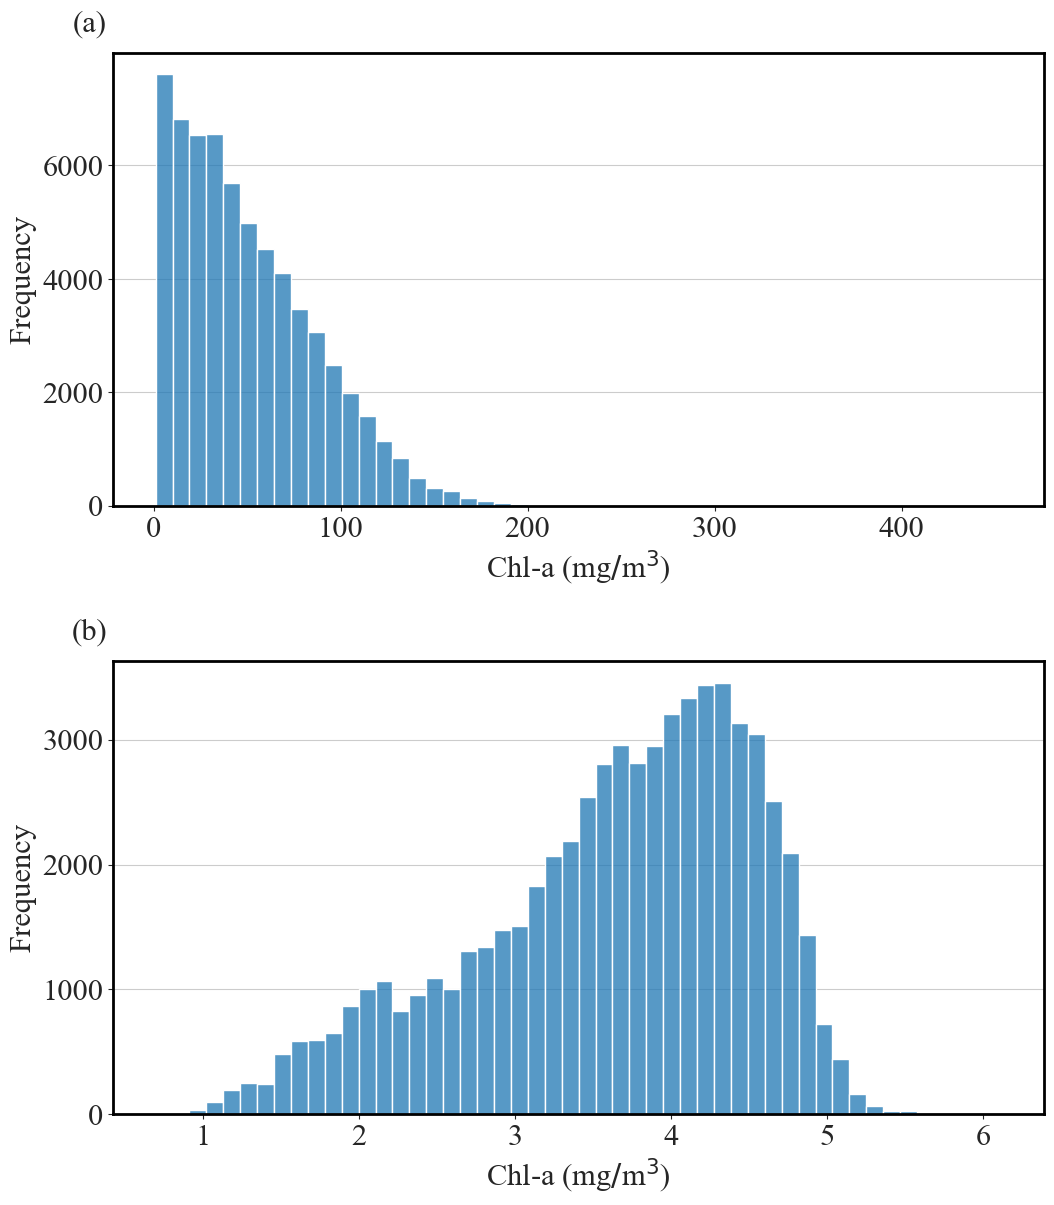

In [41]:
fig = plt.figure(figsize=(11, 12.5))
fig.subplots_adjust(hspace=0.33)

ax1 = fig.add_subplot(2, 1, 1)

ax1 = sns.histplot(scb_data['Chl-a'], bins=50)

# xticks = np.arange(0, 201, 10)
# ax1.set_xticks(xticks)
ax1.set_xlabel('Chl-a ($\mathdefault{mg}/\mathdefault{m}^3$)')
ax1.set_ylabel('Frequency')
ax1.grid(axis='y')
ax1.set_title('(a)', y=1.03, x=-0.025, fontsize=22)

ax2 = fig.add_subplot(2, 1, 2)
ax2 = sns.histplot(np.log1p(scb_data['Chl-a']), bins=50)

# xticks = np.arange(0, 201, 10)
# ax2.set_xticks(xticks)
ax2.set_xlabel('Chl-a ($\mathdefault{mg}/\mathdefault{m}^3$)')
ax2.set_ylabel('Frequency')
ax2.grid(axis='y')
ax2.set_title('(b)', y=1.03, x=-0.025, fontsize=22)

save_fig('figureS1a')
plt.show()

클로로필-a 값을 로그 변환해서 `scb_df_daily`에 추가하고 원래의 클로로필-a 특성은 삭제한다.

In [42]:
scb_data['log_Chl-a'] = np.log1p(scb_data['Chl-a'])
scb_data = scb_data.drop(['Chl-a'], axis=1)

In [43]:
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82203 entries, 2013-01-01 00:00:00 to 2022-05-23 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Temp       64548 non-null  float64
 1   EC         64498 non-null  float64
 2   TOC        58651 non-null  float64
 3   TN         59955 non-null  float64
 4   TP         58971 non-null  float64
 5   WL         82203 non-null  float64
 6   D-Flow     82203 non-null  float64
 7   log_Chl-a  62850 non-null  float64
dtypes: float64(8)
memory usage: 5.6 MB


### 결측치 보간

머신러닝 모델을 학습시키기 위해서는 일반적으로 결측치를 제거해야 한다.
여기서는 결측치는 시간을 기준으로 선형 보간법을 사용한다.
결측치는 양방향 12시간씩, 결측 구간별 최대 24시간의 결측치를 대체한다.

In [44]:
scb_df = scb_data.interpolate(method='time', limit = 12, limit_direction='both')

In [45]:
scb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82203 entries, 2013-01-01 00:00:00 to 2022-05-23 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Temp       68243 non-null  float64
 1   EC         68241 non-null  float64
 2   TOC        64092 non-null  float64
 3   TN         64508 non-null  float64
 4   TP         64252 non-null  float64
 5   WL         82203 non-null  float64
 6   D-Flow     82203 non-null  float64
 7   log_Chl-a  66385 non-null  float64
dtypes: float64(8)
memory usage: 5.6 MB


그래도 남은 결측치는 모두 제거한다.

In [46]:
scb_df = scb_df.dropna()
scb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59034 entries, 2013-03-29 04:00:00 to 2022-05-23 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Temp       59034 non-null  float64
 1   EC         59034 non-null  float64
 2   TOC        59034 non-null  float64
 3   TN         59034 non-null  float64
 4   TP         59034 non-null  float64
 5   WL         59034 non-null  float64
 6   D-Flow     59034 non-null  float64
 7   log_Chl-a  59034 non-null  float64
dtypes: float64(8)
memory usage: 4.1 MB


## 방류량과 수온의 평균값 활용

**`feature_windowing()` 함수**

지정된 특성에 대해 일(day) 단위의 윈도우(window)를 사용하여 지정된 기간동안의 평균값을 새로운 특성으로 추가한다.
특성의 기본값으로 수온과 방류량을 사용한다.

- 일(24시간) 단위로 윈도우 사용
- 일(day) 수를 지정하면 24시간 단위로 변환해서 윈도우 적용.

In [47]:
def feature_windowing(df, features=['Temp', 'D-Flow'], window=2):
    """
    df: 주어진 데이터프레임
    feature: 윈도우 적용대상 특성. 기본값은 방류량.
    window: 일(day) 단위 윈도우 크기. 기본값은 2일.
    """

    window_ = f"{window*24}H" # 일 단위를 24시간 단위로 변환

    new_features = dict()
    for ft in features:
        new_features[str(window)+'d'+ft] = df[ft].rolling(window=window_, min_periods=1).mean()
    new_features = pd.DataFrame(new_features)

    return pd.concat([df, new_features], axis=1)

예를 들어 지난 이틀 동안의 수온과 방류량의 평균값을 새로운 특성으로 추가한 결과는 다음과 같다.

In [48]:
feature_windowing(scb_df, features=['Temp', 'D-Flow'], window=2)

,Temp,EC,TOC,TN,TP,WL,D-Flow,log_Chl-a,2dTemp,2dD-Flow
DateTime,,,,,,,,,,
2013-03-29 04:00:00,13.2,296.0,3.4,5.866,0.104,7.540000,13.578333,4.332048,13.200000,13.578333
2013-03-29 05:00:00,13.1,296.0,3.3,5.866,0.104,7.540000,13.563333,4.316154,13.150000,13.570833
2013-03-29 06:00:00,12.9,296.0,3.3,5.866,0.104,7.540000,13.578333,4.300003,13.066667,13.573333
2013-03-29 07:00:00,12.6,294.0,3.3,5.866,0.104,7.536667,13.193333,4.218036,12.950000,13.478333
2013-03-29 08:00:00,12.5,292.0,3.3,5.866,0.104,7.530000,12.333333,4.158883,12.860000,13.249333
...,...,...,...,...,...,...,...,...,...,...
2022-05-23 19:00:00,26.6,419.0,6.7,5.825,0.108,5.440000,12.766667,4.207673,24.570833,11.447187
2022-05-23 20:00:00,26.3,425.0,6.5,5.803,0.107,5.440000,12.786667,4.130355,24.616667,11.447812
2022-05-23 21:00:00,25.9,417.0,6.7,5.909,0.107,5.440000,12.743333,4.082609,24.656250,11.448750


## 모델 훈련

**훈련 특성과 타깃**

- 훈련 특성: 클로로필-a를 제외한 특성 + 최대 14일 동안의 방류량/수온 평균값
- 타깃 특성: `log_Chl-a`

In [49]:
scb_df.columns

Index(['Temp', 'EC', 'TOC', 'TN', 'TP', 'WL', 'D-Flow', 'log_Chl-a'], dtype='object')

In [50]:
features_to_remove = ['log_Chl-a']
basic_features = ['Temp', 'EC', 'TOC', 'TN', 'TP', 'WL', 'D-Flow']

### GradientBoosting

In [51]:
gb_reg = GradientBoostingRegressor(random_state=42)

이전 훈련 결과에 의해 하이퍼파라미터의 아래 조합이 가장 좋은 성능을 보였다.
따라서 여기서는 훈련 시간을 절약하기 위해 하나의 조합만 사용한다.

In [52]:
param_grid = {
    "subsample":[0.6],
    'max_depth':[10], 
    "learning_rate":[0.05],
    'n_estimators':[1200]
    }


훈련된 최고의 모델을 저장할 디렉토리를 지정한다.

In [53]:
best_models_path = Path() / "best_models_1"
best_models_path.mkdir(parents=True, exist_ok=True)

**`gridsearch()` 함수**

그리드 탐색 훈련을 진행한다.

- 모델, 하이퍼파라미터 조합, 특성, 윈도우 크기가 정해지면 해당 특성의 지정된 크기만큼의 윈도우 기간 동안의 평균값을 새로운 특성으로 추가한다.

In [57]:
def gridsearch(dataset, model, parameters, features=['Temp', 'D-Flow'], windows=range(1, 15), cv=3):

    # best models
    best_model_dict = dict()
    # best models names
    best_model_name_dict = dict()
    # test r2 scores of the best models
    test_score_dict = dict()
    # test rmse scores of the best models
    test_score_rmse_dict = dict()
    # train features of the best models
    input_features_dict = dict()
    # best hyperparameters for each window
    best_params_dict = dict()
    
    for window in windows:
        # window 특성 추가
        dataset_window = feature_windowing(dataset, features, window)
        # 결측치 제거
        dataset_window.dropna(inplace=True)

        # 입력 및 타깃 특성 지정
        features_to_be_removed = ['log_Chl-a']+features
        features_ = list(dataset_window.columns)
        for ft in features_to_be_removed:
            features_.remove(ft)
        
        input_features = features_
        target_feature = 'log_Chl-a'

        # 입력 및 타깃 데이터셋 지정
        inputs = dataset_window.loc[:, input_features]
        targets = dataset_window[target_feature]

        # 훈련셋과 테스트셋 분리
        X_train, X_test, y_train, y_test = train_test_split(inputs, targets, random_state=42)

        # 그리드 탐색 훈련 시작
        added_feature = window
        print(f"==={added_feature}day(s) temperature and discharge added===")

        model_grid = GridSearchCV(model, param_grid=parameters, cv=cv, verbose=5, scoring=['r2', 'neg_mean_squared_error'], refit='r2')
        model_grid.fit(X_train, y_train)

        # 최적 모델 저장
        estimator = model_grid.best_estimator_

        best_model = str(added_feature)+"days"+".pkl"
        joblib.dump(estimator, best_models_path / best_model)

        # 저장된 모델 다시 불러오기
        estimator = joblib.load(best_models_path / best_model)

        best_model_dict[added_feature] = estimator
        best_model_name_dict[added_feature] = best_model
        test_score_dict[added_feature] = estimator.score(X_test, y_test)
        test_score_rmse_dict[added_feature] = np.sqrt(mean_squared_error(y_test, estimator.predict(X_test)))
        input_features_dict[added_feature] = input_features
        best_params_dict[added_feature] = model_grid.best_params_

    return best_model_dict, best_model_name_dict, test_score_dict, test_score_rmse_dict, input_features_dict, best_params_dict


수온과 방류량을 기준으로 1일부터 14일까지의 윈도우를 개별적으로 적용하여 훈련한다.

In [53]:
window_features = ['Temp', 'D-Flow']
windows = range(1, 15)

dicts = gridsearch(scb_df, gb_reg, param_grid, window_features, windows, cv=3)
best_model_dict, best_model_name_dict, test_score_dict, test_score_rmse_dict, input_features_dict, best_params_dict = dicts

===1day(s) temperature and discharge added===
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END learning_rate=0.05, max_depth=10, n_estimators=1200, subsample=0.6; neg_mean_squared_error: (test=-0.029) r2: (test=0.963) total time= 4.3min
[CV 2/3] END learning_rate=0.05, max_depth=10, n_estimators=1200, subsample=0.6; neg_mean_squared_error: (test=-0.029) r2: (test=0.964) total time= 4.3min
[CV 3/3] END learning_rate=0.05, max_depth=10, n_estimators=1200, subsample=0.6; neg_mean_squared_error: (test=-0.031) r2: (test=0.962) total time= 3.9min
===2day(s) temperature and discharge added===
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END learning_rate=0.05, max_depth=10, n_estimators=1200, subsample=0.6; neg_mean_squared_error: (test=-0.025) r2: (test=0.968) total time= 4.1min
[CV 2/3] END learning_rate=0.05, max_depth=10, n_estimators=1200, subsample=0.6; neg_mean_squared_error: (test=-0.025) r2: (test=0.969) total time= 4.1min
[CV 3/3] END le

**best_params_dict**

In [54]:
best_params_dict


{1: {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 1200,
  'subsample': 0.6},
 2: {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 1200,
  'subsample': 0.6},
 3: {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 1200,
  'subsample': 0.6},
 4: {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 1200,
  'subsample': 0.6},
 5: {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 1200,
  'subsample': 0.6},
 6: {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 1200,
  'subsample': 0.6},
 7: {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 1200,
  'subsample': 0.6},
 8: {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 1200,
  'subsample': 0.6},
 9: {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 1200,
  'subsample': 0.6},
 10: {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 1200,
  'subsample': 0.6},
 11: {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 1200,
  'subs

**훈련된 최고 모델의 정보 저장**

In [55]:
import json

file_name = 'best_model_name.json'
with open(best_models_path / file_name, 'w') as json_file:
    json.dump(best_model_name_dict, json_file)

file_name = 'test_score.json'
with open(best_models_path / file_name, 'w') as json_file:
    json.dump(test_score_dict, json_file)

file_name = 'test_score_rmse.json'
with open(best_models_path / file_name, 'w') as json_file:
    json.dump(test_score_rmse_dict, json_file)

file_name = 'best_params.json'
with open(best_models_path / file_name, 'w') as json_file:
    json.dump(best_params_dict, json_file)

file_name = 'input_features.json'
with open(best_models_path / file_name, 'w') as json_file:
    json.dump(input_features_dict, json_file)

**최고 성능 모델 정보 불러오기**

In [54]:
import json

file_name = 'best_model_name.json'
with open(best_models_path / file_name) as json_file:
    best_model_name_dict = json.load(json_file)

file_name = 'test_score.json'
with open(best_models_path / file_name) as json_file:
    test_score_dict = json.load(json_file)

file_name = 'test_score_rmse.json'
with open(best_models_path / file_name) as json_file:
    test_score_rmse_dict = json.load(json_file)

file_name = 'best_params.json'
with open(best_models_path / file_name) as json_file:
    best_params_dict = json.load(json_file)

file_name = 'input_features.json'
with open(best_models_path / file_name) as json_file:
    input_features_dict = json.load(json_file)

## 최고 모델 특성 파악

### 특성 중요도

아래 함수는 훈련 후 각 특성의 중요도를 그래프로 그린다.

In [55]:
best_model_name_dict.keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'])

In [56]:
def feature_importance_barplot(best_model_name_dict, input_features_dict):
    models_trained = best_model_name_dict.keys()
    num_of_models = len(models_trained)

    fig, axs = plt.subplots(num_of_models, sharex=True, figsize=(10, num_of_models*4))

    for idx, model_name in enumerate(models_trained):
        ax = axs[idx]
        # 저장된 모델 다시 불러오기
        best_model = model_name+"days.pkl"
        estimator_ = joblib.load(best_models_path / best_model)
        # 모델이 사용한 특성들 확인
        input_features_ = input_features_dict[model_name]
        # 특성 중요도 확인
        feature_series = pd.Series(data = estimator_.feature_importances_, index = input_features_)
        feature_series = feature_series.sort_values(ascending = False)
        # 특성 중요도 막대그래프
        colors = pd.Series('gray', index=feature_series.index)
        colors[input_features_[-1]] = 'red'
        colors[input_features_[-2]] = 'blue'
        sns.barplot(ax=ax, x = feature_series[:10], y = feature_series.index[:10], palette=colors)
        ax.set_title(model_name)

    plt.subplots_adjust(hspace=0.4, wspace=0)
    plt.show()

윈도우 크기 1부터 14까지 훈련시킨 결과 각 특성의 중요도를 그래프로 그리면 다음과 같다.

- 윈도우 크기 9까지 방류량 중요도가 가장 높음.
- 윈도우 크기 4까지 방류량의 중요도가 계속 증가함.

In [57]:
str(best_models_path / "1days.pkl")

'best_models_1\\1days.pkl'

<Figure size 2000x10000 with 0 Axes>

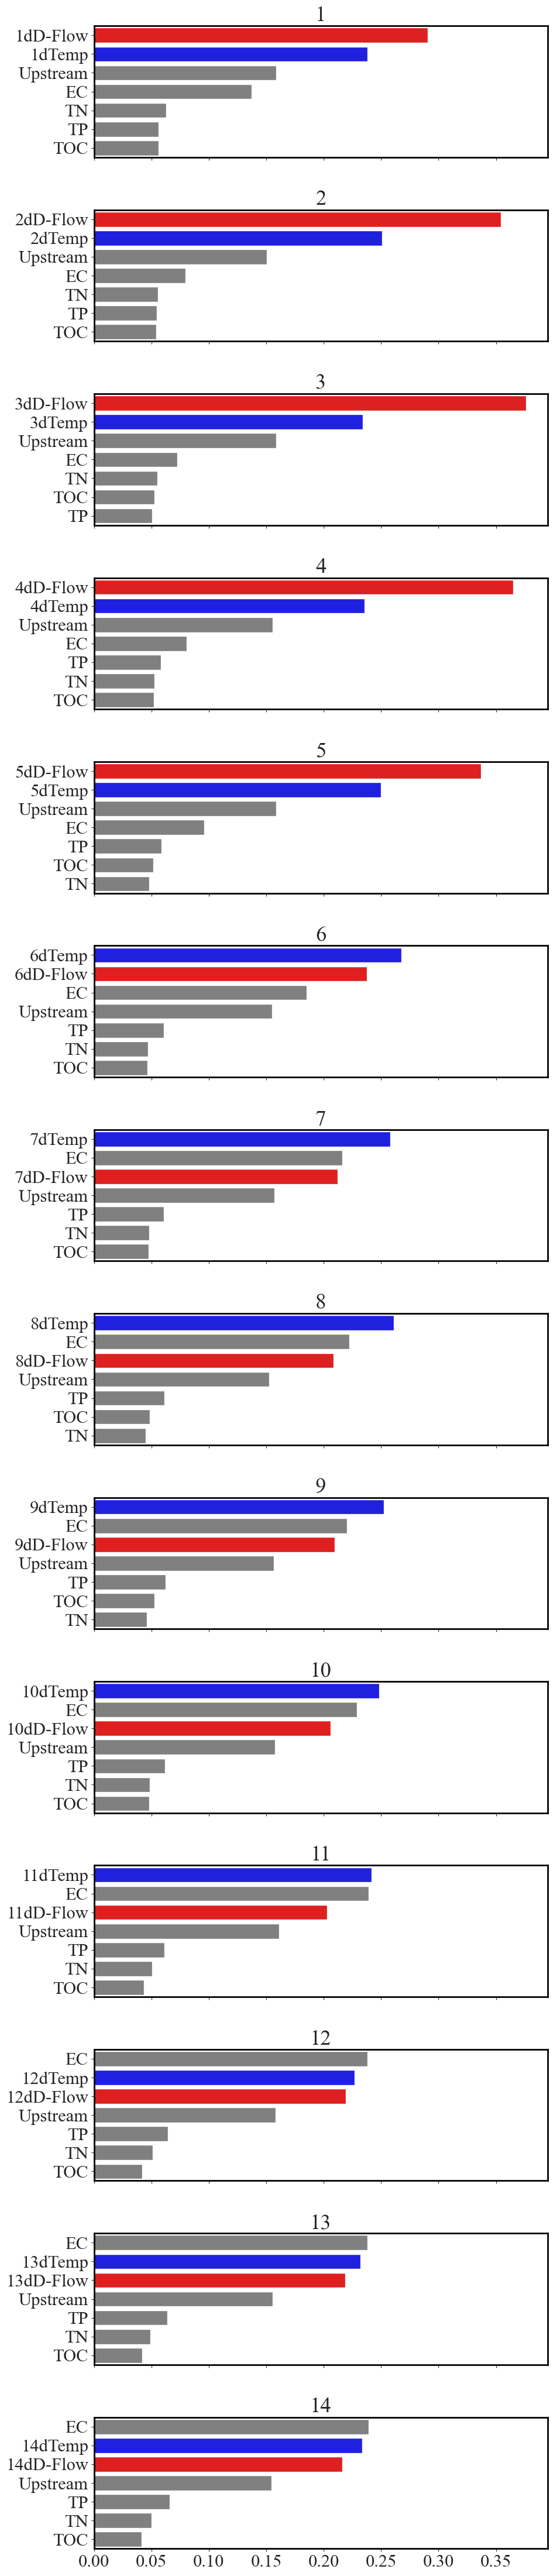

In [58]:
plt.figure(figsize=(20, 100))

feature_importance_barplot(best_model_name_dict, input_features_dict)

**평균 방류량 별 최선 모델의 특성 중요도**

모델 훈련에 사용된 특성을 통합하기 위해 `'?dTemp'`/`'?dDischarge'`를 `'Temp'`/`'D-Flow'`로 통일시킨 후
최선 모델의 중요도로 구성된 사전을 구현한다.

In [59]:
# 평균 방류량 별 모델의 특성 중요도

models_trained = best_model_name_dict.keys()

# 최선 모델 별 특성 중요도로 구성된 사전
feature_importance_dict = dict()
    
for model_name in models_trained:
    # 저장된 모델 다시 불러오기
    best_model = model_name+"days.pkl"
    estimator_ = joblib.load(best_models_path / best_model)
    
    input_features_ = input_features_dict[model_name]

    feature_series = pd.Series(data = estimator_.feature_importances_, index = input_features_)
    
    # 특성 통일시키기
    features = ['EC', 'TOC', 'TN', 'TP', 'WL', 'Temp', 'D-Flow']
    feature_series.index = features

    feature_importance_dict[model_name] = feature_series    

특성의 순서를 재배치하여 데이터프레임으로 구성한다.
인덱스는 방류량 별 모델이 사용된다.

In [60]:
# 데이터프레임 지정. 인덱스는 모델명.
feature_importance_df = pd.DataFrame(feature_importance_dict).T

# 특성 순서 재배치
features_reorderd = ['D-Flow', 'Temp', 'WL', 'EC', 'TP', 'TN', 'TOC']
feature_importance_df = feature_importance_df[features_reorderd]
feature_importance_df

,D-Flow,Temp,WL,EC,TP,TN,TOC
1,0.290752,0.237984,0.158717,0.137334,0.056213,0.062972,0.056028
2,0.354287,0.250926,0.150509,0.079521,0.054816,0.055914,0.054027
3,0.376051,0.234036,0.158628,0.072793,0.050800,0.055240,0.052452
4,0.364934,0.235602,0.155647,0.080809,0.058101,0.052811,0.052096
5,0.336951,0.249762,0.158421,0.095956,0.059026,0.048280,0.051604
6,0.237745,0.267715,0.155247,0.185248,0.060719,0.047012,0.046315
7,0.211917,0.258203,0.157352,0.216239,0.060849,0.047954,0.047486
8,0.208809,0.260998,0.152573,0.222404,0.061569,0.045138,0.048508
9,0.209743,0.252216,0.156559,0.220160,0.062567,0.046274,0.052480
10,0.206286,0.248550,0.157832,0.228925,0.061682,0.048466,0.048260


**모델별 특성 중요도 막대그래프**

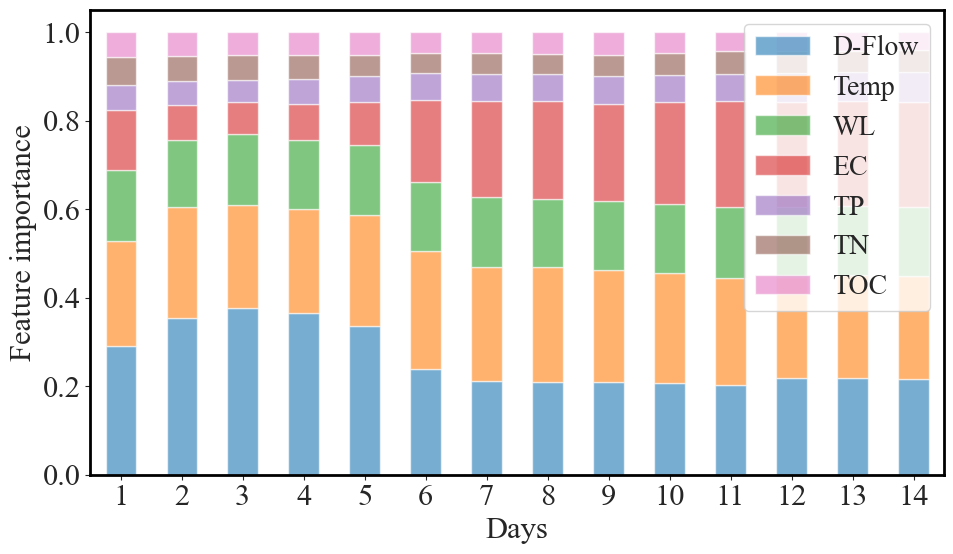

In [61]:
ax = feature_importance_df.plot(kind='bar', stacked=True, alpha=0.6)

ax.legend(loc='upper right')
ax.set_xlabel('Days')
ax.set_ylabel('Feature importance')
days = len(feature_importance_df)
ax.set_xticks(range(days))
# ax.set_xticklabels([str(day)+"D" for day in range(1, days+1)], rotation=0)
ax.set_xticklabels([str(day) for day in range(1, days+1)], rotation=0)
# ax.set_xticklabels(range(1, days+1), rotation=0)
# ax.set_title('Importance features for Mean of Discharge')

ax.legend(loc='upper right', fontsize=20)

save_fig('Discharge-Importance-Histogram')
plt.show()

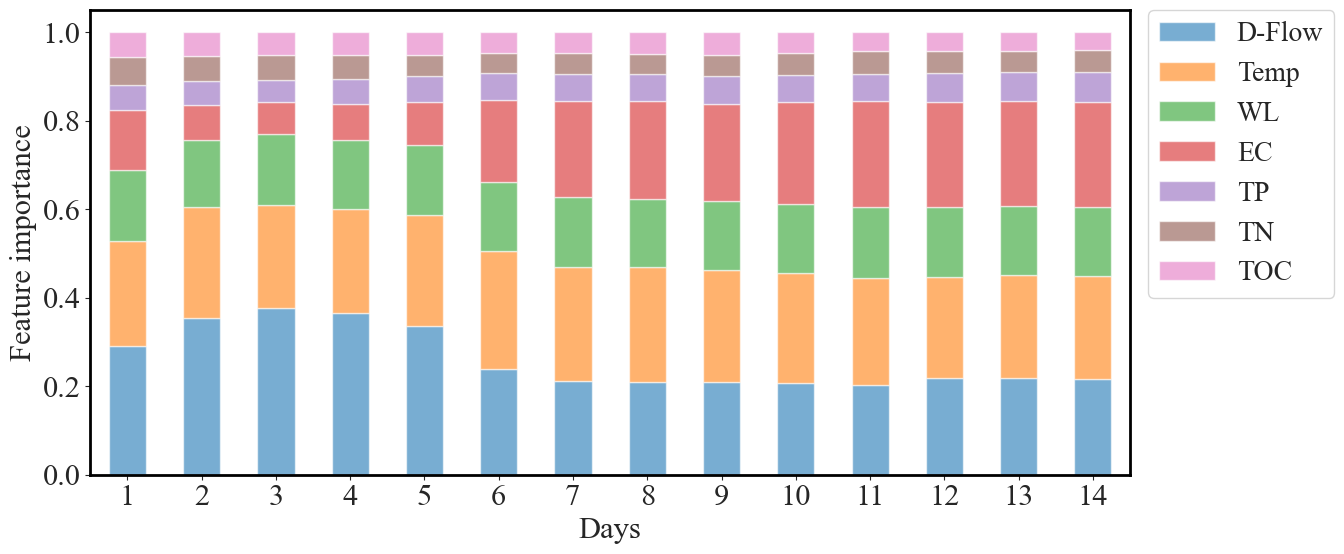

In [62]:
ax = feature_importance_df.plot(kind='bar', stacked=True, alpha=0.6, figsize=(14, 6))

ax.set_xlabel('Days')
ax.set_ylabel('Feature importance')
days = len(feature_importance_df)
ax.set_xticks(range(days))
# ax.set_xticklabels([str(day)+"D" for day in range(1, days+1)], rotation=0)
ax.set_xticklabels([str(day) for day in range(1, days+1)], rotation=0)
# ax.set_xticklabels(range(1, days+1), rotation=0)
# ax.set_title('Importance features for Mean of Discharge')

ax.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.21, 1.03))

save_fig('figure-abstract-1')
plt.show()

### 모델 성능

아래 그래프는 윈도우 크기에 따른 모델의 테스트 성능(score 기준)의 변화를 보여준다.
정확도의 성능이 최고 0.971328까지 올라간다.

In [63]:
r2_df = pd.DataFrame(test_score_dict, index=['$\mathdefault{R}^2$']).T
r2_df

,$\mathdefault{R}^2$
1,0.972864
2,0.977074
3,0.978234
4,0.979630
5,0.980626
6,0.981308
7,0.981424
8,0.981196
9,0.981877
10,0.981992


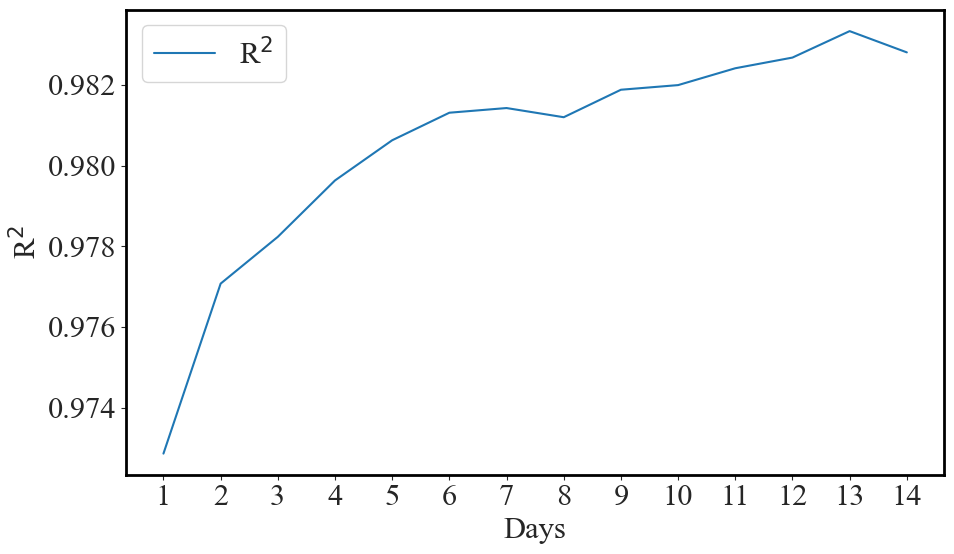

In [64]:
ax = r2_df.plot()

ax.set_xlabel('Days')
ax.set_ylabel('$\mathdefault{R}^2$')
days = len(r2_df.index)
ax.set_xticks(range(days))
ax.set_xticklabels([str(day) for day in range(1, days+1)], rotation=0)
# ax.set_title('R2 Scores for Mean of Flow')

save_fig('Discharge_score_mean')
plt.show()

In [65]:
neg_rmse_df = - pd.DataFrame(test_score_rmse_dict, index=['neg. RMSE']).T
neg_rmse_df

,neg. RMSE
1,-0.146609
2,-0.134756
3,-0.131305
4,-0.127023
5,-0.123880
6,-0.121679
7,-0.121302
8,-0.122042
9,-0.119813
10,-0.119432


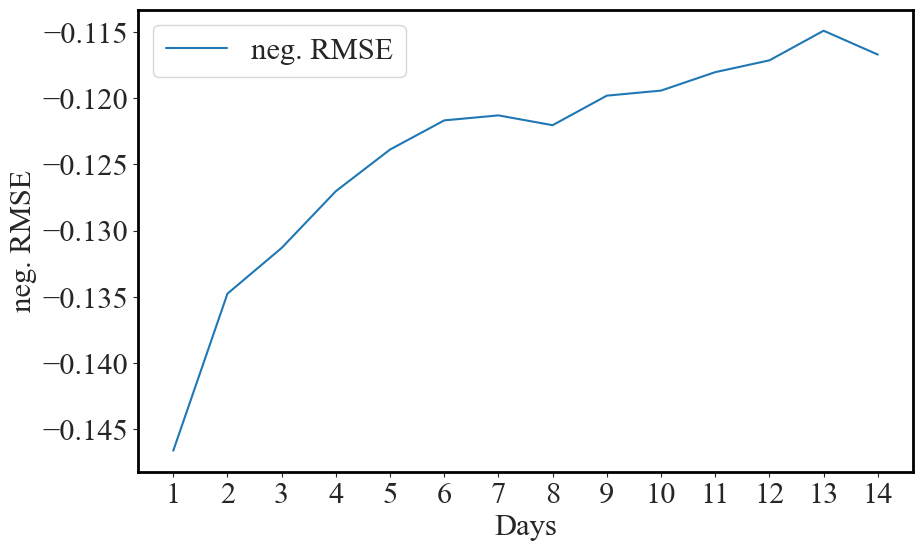

In [66]:
ax = neg_rmse_df.plot()

ax.set_xlabel('Days')
ax.set_ylabel('neg. RMSE')
days = len(neg_rmse_df.index)
ax.set_xticks(range(days))
ax.set_xticklabels([str(day) for day in range(1, days+1)], rotation=0)
# ax.set_title('RMSE for Mean of Flow')

# save_fig('Discharge_score_mean')
plt.show()

두 점수를 한 번에 표시한다.

In [67]:
score_df = pd.concat([r2_df, neg_rmse_df], axis=1)
score_df

,$\mathdefault{R}^2$,neg. RMSE
1,0.972864,-0.146609
2,0.977074,-0.134756
3,0.978234,-0.131305
4,0.979630,-0.127023
5,0.980626,-0.123880
6,0.981308,-0.121679
7,0.981424,-0.121302
8,0.981196,-0.122042
9,0.981877,-0.119813
10,0.981992,-0.119432


In [68]:
from matplotlib import colormaps as cm

def plot_df(df, x_column, columns):

    cmap = cm.get_cmap('tab10')

    fig, ax = plt.subplots(figsize = (11, 6))

    axes = [ax]
    handles = []

    for i, _ in enumerate(range(len(columns) - 1)):
        twin = ax.twinx()
        axes.append(twin)
        twin.spines.right.set_position(("axes", 1 + i/10))

    j = 0
    for i, col in enumerate(columns):
        ylabel = []
        
        if len(col) == 1:
            p, = axes[i].plot(df[x_column], df[col[0]], label = col[0], color = cmap(j)[:3])
            ylabel.append(col[0])
            handles.append(p)
            j += 1
        else:
            for sub_col in col:
                p, = axes[i].plot(df[x_column], df[sub_col], label = sub_col, color = cmap(j)[:3])
                ylabel.append(sub_col)
                handles.append(p)
                j += 1

        axes[i].set_ylabel(', '.join(ylabel), x=1, labelpad=15)

    ax.legend(handles = handles, frameon = True)
    ax.set_xlabel(x_column)

    # ax.grid(axis='x')

    # plt.tight_layout()

    plt.show()

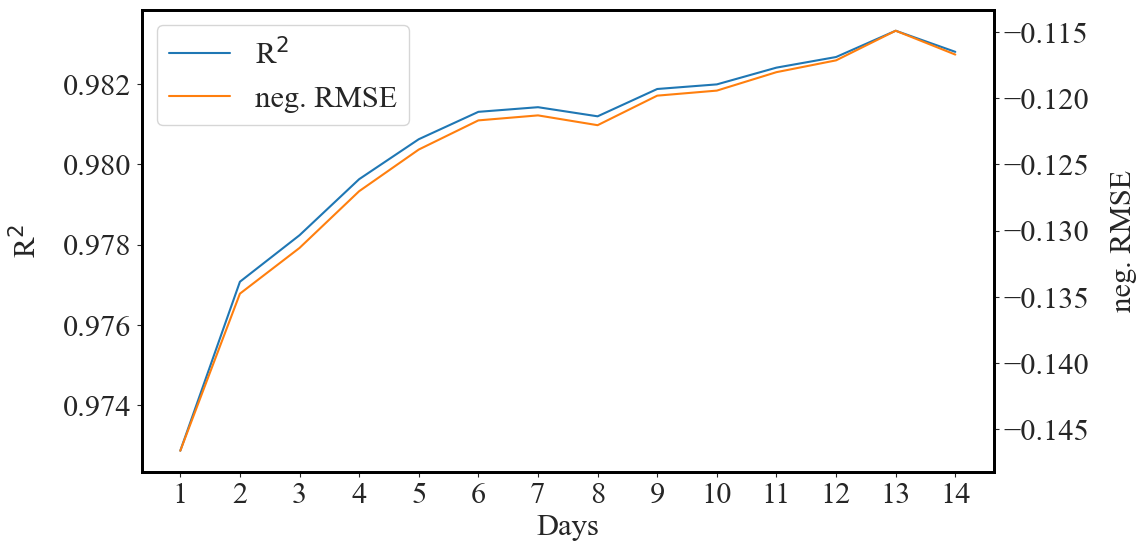

In [69]:
plot_df(score_df.reset_index().rename(columns={'index':'Days'}), 'Days', [['$\mathdefault{R}^2$'], ['neg. RMSE']])

In [70]:
from matplotlib import colormaps as cm

def plot_df(df, x_column, columns):

    cmap = cm.get_cmap('tab10')

    fig, ax = plt.subplots(figsize = (11, 6))

    axes = [ax]
    handles = []

    for i, _ in enumerate(range(len(columns) - 1)):
        twin = ax.twinx()
        axes.append(twin)
        twin.spines.right.set_position(("axes", 1 + i/10))

    j = 0
    for i, col in enumerate(columns):
        ylabel = []
        
        if len(col) == 1:
            p, = axes[i].plot(df[x_column], df[col[0]], label = col[0], color = cmap(j)[:3])
            ylabel.append(col[0])
            handles.append(p)
            j += 1
        else:
            for sub_col in col:
                p, = axes[i].plot(df[x_column], df[sub_col], label = sub_col, color = cmap(j)[:3])
                ylabel.append(sub_col)
                handles.append(p)
                j += 1

        axes[i].set_ylabel(', '.join(ylabel), x=1, labelpad=15)

    ax.legend(handles = handles, frameon = True)
    ax.set_xlabel(x_column)

    ax.grid(axis='x')

    # plt.tight_layout()

    plt.show()

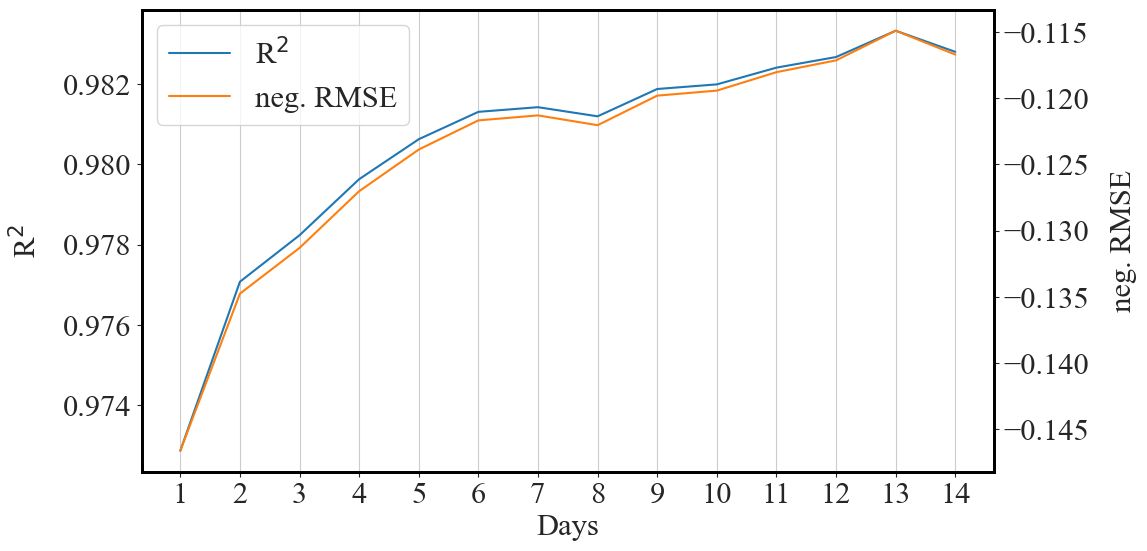

In [71]:
plot_df(score_df.reset_index().rename(columns={'index':'Days'}), 'Days', [['$\mathdefault{R}^2$'], ['neg. RMSE']])

In [72]:
from matplotlib import colormaps as cm

def plot_df_(ax, df, x_column, columns):

    cmap = cm.get_cmap('tab10')

    axes = [ax]
    handles = []

    for i, _ in enumerate(range(len(columns) - 1)):
        twin = ax.twinx()
        axes.append(twin)
        twin.spines.right.set_position(("axes", 1 + i/10))

    j = 0
    for i, col in enumerate(columns):
        ylabel = []
        
        if len(col) == 1:
            p, = axes[i].plot(df[x_column], df[col[0]], label = col[0], color = cmap(j)[:3])
            ylabel.append(col[0])
            handles.append(p)
            j += 1
        else:
            for sub_col in col:
                p, = axes[i].plot(df[x_column], df[sub_col], label = sub_col, color = cmap(j)[:3])
                ylabel.append(sub_col)
                handles.append(p)
                j += 1

        axes[i].set_ylabel(', '.join(ylabel), x=1, labelpad=15)

    ax.legend(handles = handles, frameon = True, loc = 'lower right')
    ax.set_xlabel(x_column)
    ax.grid(axis='x')

    plt.tight_layout(h_pad=2)

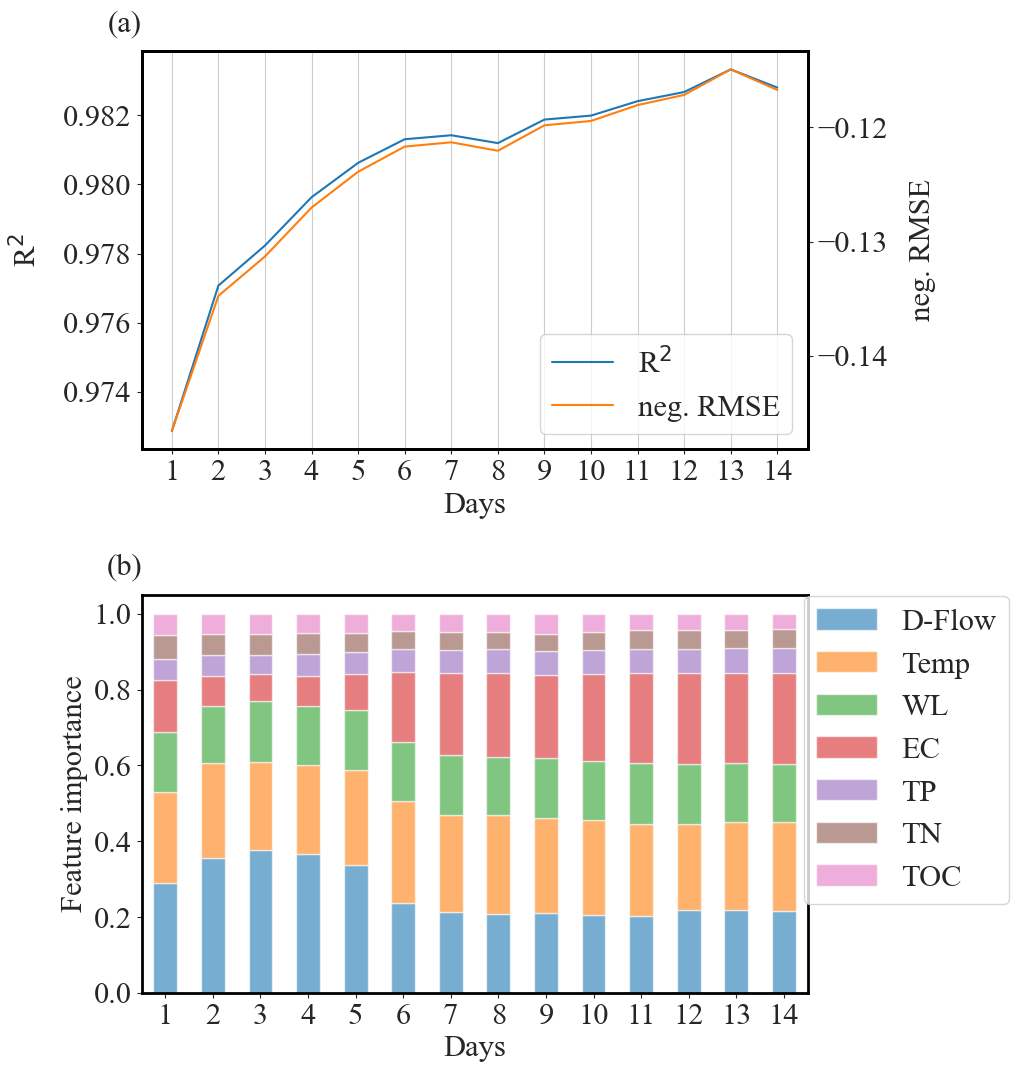

In [73]:
fig = plt.figure(figsize=(11, 11.2))
# fig.subplots_adjust(hspace=30)

ax1 = fig.add_subplot(2, 1, 1)
plot_df_(ax1, score_df.reset_index().rename(columns={'index':'Days'}), 'Days', [['$\mathdefault{R}^2$'], ['neg. RMSE']])

ax1.set_title('(a)', y=1.03, x=-0.025, fontsize=22)

ax2 = fig.add_subplot(2, 1, 2)
feature_importance_df.plot(ax=ax2, kind='bar', stacked=True, alpha=0.6)

ax2.legend(loc='upper right', fontsize=22, bbox_to_anchor=(1.325, 1.035))
ax2.set_xlabel('Days', fontsize=22)
ax2.set_ylabel('Feature importance', fontsize=22)
days = len(feature_importance_df)
ax2.set_xticks(range(days))
ax2.set_xticklabels([str(day) for day in range(1, days+1)], rotation=0)

ax2.set_title('(b)', y=1.03, x=-0.025, fontsize=22)

save_fig('figure5a')
plt.show()

In [74]:
from matplotlib import colormaps as cm

def plot_df_(ax, df, x_column, columns):

    cmap = cm.get_cmap('tab10')

    axes = [ax]
    handles = []

    for i, _ in enumerate(range(len(columns) - 1)):
        twin = ax.twinx()
        axes.append(twin)
        twin.spines.right.set_position(("axes", 1 + i/10))

    j = 0
    for i, col in enumerate(columns):
        ylabel = []
        
        if len(col) == 1:
            p, = axes[i].plot(df[x_column], df[col[0]], label = col[0], color = cmap(j)[:3])
            ylabel.append(col[0])
            handles.append(p)
            j += 1
        else:
            for sub_col in col:
                p, = axes[i].plot(df[x_column], df[sub_col], label = sub_col, color = cmap(j)[:3])
                ylabel.append(sub_col)
                handles.append(p)
                j += 1

        axes[i].set_ylabel(', '.join(ylabel), x=1, labelpad=15)

    ax.legend(handles = handles, frameon = True, loc = 'lower right')
    ax.set_xlabel(x_column)
    # ax.grid(axis='x')

    plt.tight_layout(h_pad=2)

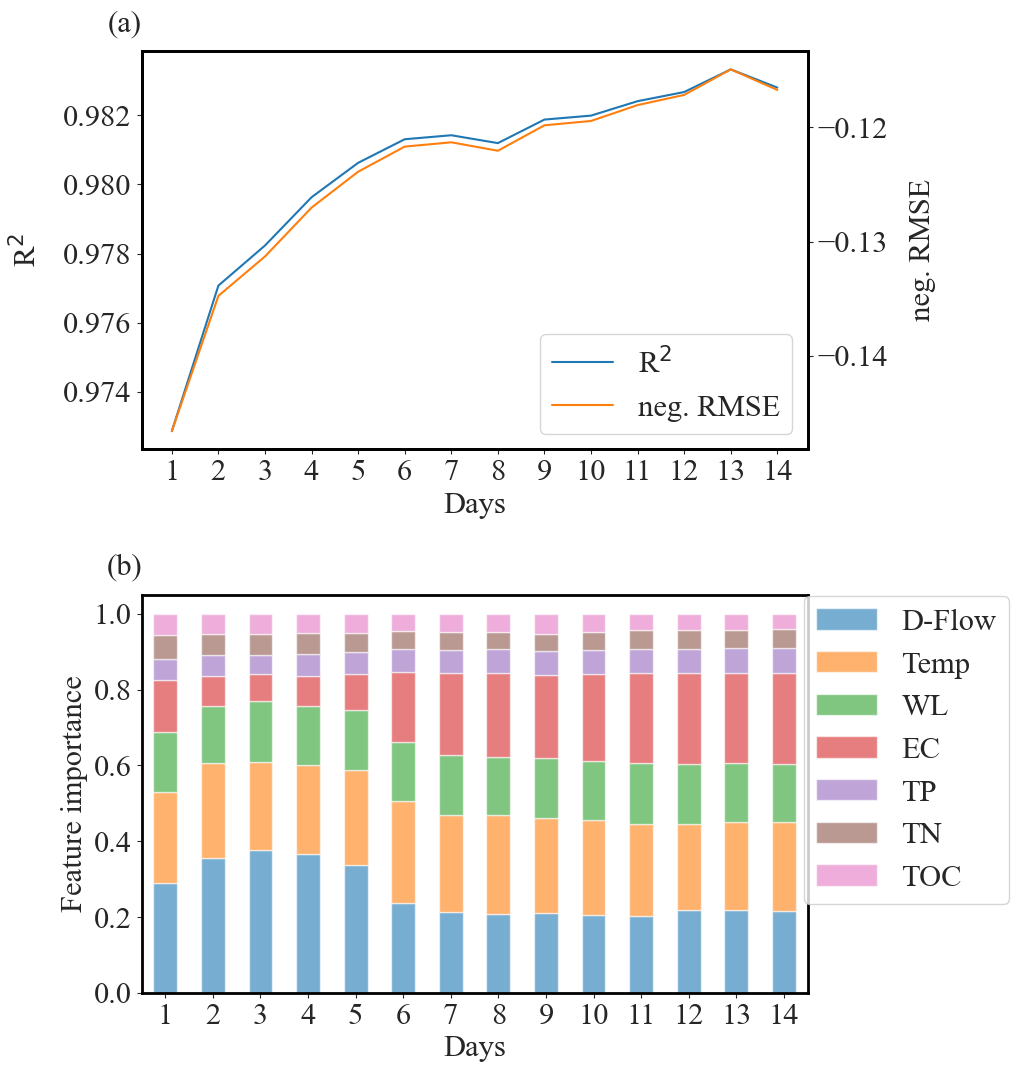

In [75]:
fig = plt.figure(figsize=(11, 11.2))
# fig.subplots_adjust(hspace=30)

ax1 = fig.add_subplot(2, 1, 1)
plot_df_(ax1, score_df.reset_index().rename(columns={'index':'Days'}), 'Days', [['$\mathdefault{R}^2$'], ['neg. RMSE']])

ax1.set_title('(a)', y=1.03, x=-0.025, fontsize=22)

ax2 = fig.add_subplot(2, 1, 2)
feature_importance_df.plot(ax=ax2, kind='bar', stacked=True, alpha=0.6)

ax2.legend(loc='upper right', fontsize=22, bbox_to_anchor=(1.325, 1.035))
ax2.set_xlabel('Days', fontsize=22)
ax2.set_ylabel('Feature importance', fontsize=22)
days = len(feature_importance_df)
ax2.set_xticks(range(days))
ax2.set_xticklabels([str(day) for day in range(1, days+1)], rotation=0)

ax2.set_title('(b)', y=1.03, x=-0.025, fontsize=22)

save_fig('figure5')
plt.show()